# 4M-21: An Any-to-Any Vision Model for Tens of Tasks and Modalities

Roman Bachmann\*, Oguzhan Fatih Kar\*, David Mizrahi\*, Ali Garjani, Mingfei Gao, David Griffiths, Jiaming Hu, Afshin Dehghan, Amir Zamir

(\* Equal contribution, random order)

[`Website`](https://4m.epfl.ch) | [`Paper`](https://arxiv.org/abs/2406.09406) | [`GitHub`](https://github.com/apple/ml-4m)

We adopt the 4M framework to scale a vision model to tens of tasks and modalities. The resulting model, named 4M-21, has significantly expanded out-of-the-box capabilities, and yields stronger results on downstream transfer tasks. 

The diverse set of modalities we incorporated unlock new potential for multimodal interaction, such as retrieval from and across multiple modalities, or highly steerable generation of any of the training modalities, all in a single model.

This notebook contains examples for 4M-21 inference, specifically performing conditional image generation and common vision tasks (i.e. RGB-to-All).

In [1]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import center_crop
from tokenizers import Tokenizer
import matplotlib.pyplot as plt

from fourm.models.fm import FM
from fourm.vq.vqvae import VQVAE, DiVAE
from fourm.models.generate import GenerationSampler, build_chained_generation_schedules, init_empty_target_modality, init_full_input_modality, custom_text
from fourm.data.modality_transforms import RGBTransform
from fourm.data.modality_info import MODALITY_INFO
from fourm.utils.plotting_utils import decode_dict, visualize_bboxes, plot_text_in_square

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

### Load tokenizers

To encode modalities into discrete tokens, and in turn decode the tokens that 4M predicts, we use modality-specific tokenizers. We can easily load them from [Hugging Face hub](https://huggingface.co/EPFL-VILAB) with the below lines.

The tokenizer checkpoint names are formated as: `f'4M_tokenizers_{modality}_{vocab_size}_{min_res}-{max–res}'`.
All tokenizers here are trained to work on resolutions between 224 and 448, in steps of 32.

In [3]:
text_tok = Tokenizer.from_file('./fourm/utils/tokenizer/trained/text_tokenizer_4m_wordpiece_30k.json')

toks = {
    'tok_rgb': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_rgb_16k_224-448').eval().to(device),
    'tok_depth': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_depth_8k_224-448').eval().to(device),
    'tok_normal': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_normal_8k_224-448').eval().to(device),
    'tok_canny_edge': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_edge_8k_224-512').eval().to(device),
    'tok_sam_edge': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_edge_8k_224-512').eval().to(device),
    'tok_semseg': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_semseg_4k_224-448').eval().to(device),
    'tok_clip': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_CLIP-B16_8k_224-448').eval().to(device),
    'tok_dinov2': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_DINOv2-B14_8k_224-448').eval().to(device),
    'tok_imagebind': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_ImageBind-H14_8k_224-448').eval().to(device),
    'sam_instance': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_sam-instance_1k_64').eval().to(device),
    'human_poses': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_human-poses_1k_8').eval().to(device),
}

### Load a 4M-21 model

Let's load a 4M-21 XL model that was trained on 21 modalities, including RGB, depth, surface normals, semantic segmentation, SAM instances, Canny & SAM edges, 3D human poses, CLIP-B/16 features, DINOv2-B/14 features, ImageBind-H/14 features, captions, metadata, color palette and bounding boxes. It can take any combination of those modalities as input, and can predict all of them. We wrap the model in a `GenerationSampler` which provides inference utilities.

Please see [official repo's](https://github.com/apple/ml-4m) `README.md` for all available 4M and tokenizer models.

In [4]:
fm = FM.from_pretrained('EPFL-VILAB/4M-21_XL').eval().to(device)
sampler = GenerationSampler(fm)

### RGB → All

Given an RGB input, predict all other modalities. Inference/generation is done by providing a _generation schedule_ to the `GenerationSampler`. 
A _generation schedule_ specifies the order of modalities to generate, and for each it contains the generation parameters like number of steps or temperature.
We provide a convenience function `build_chained_generation_schedules` that allows for building arbitrary chained generation schedules.
We call it chained generation, since every newly generated output is looped back into the input and serves as conditioning for subsequently generated modalities.
This enables generating multiple modalities that are all consistent with each other, which is mostly important when the conditioning is underspecified.
Please see the paper for more details on chained generation.

The `build_chained_generation_schedules` function takes several inputs. 
Please see the generation README in `README_GENERATION.md` for detailed information on each of them, and tips on how to set them.
In the following, we give an RGB image as input (pixels not tokens), and predict all other modalities from it.

In [5]:
cond_domains = ['rgb@224']
target_domains = [
    'tok_clip@224', 'tok_dinov2@224', 'tok_imagebind@224', 'tok_depth@224', 
    'tok_normal@224', 'tok_semseg@224', 'tok_canny_edge@224', 'tok_sam_edge@224', 
    'caption', 'det', 'human_poses', 'sam_instance', 'color_palette', 'metadata'
]
tokens_per_target = [196, 256, 256, 196, 196, 196, 196, 196, 256, 256, 275, 256, 23, 40]
autoregression_schemes = [
    'roar', 'roar', 'roar', 'roar', 'roar', 'roar', 'roar', 'roar', 
    'autoregressive', 'autoregressive', 'autoregressive', 'autoregressive', 
    'autoregressive', 'autoregressive'
]
decoding_steps = [1, 1, 1, 1, 1, 1, 1, 1, None, None, None, None, None, None]
token_decoding_schedules = [
    'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 'linear', 
    None, None, None, None, None, None
]
temps = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.3, 0.7, 0.1, 0.01, 0.1, 0.1]
temp_schedules = ['constant'] * len(target_domains)
cfg_scales = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
cfg_schedules = ['constant'] * len(target_domains)
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  217k  100  217k    0     0   228k      0 --:--:-- --:--:-- --:--:--  227k


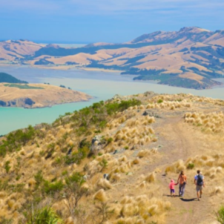

In [6]:
# Download image from the specified URL and preprocess it
image_url = 'https://storage.googleapis.com/four_m_site/images/demo_rgb.png'
!curl $image_url --output input.jpg

rgb_transform = RGBTransform(imagenet_default_mean_and_std=True)
img_pil = rgb_transform.load('./input.jpg')
img_pil = rgb_transform.preprocess(img_pil)
img_pil = center_crop(img_pil, (min(img_pil.size), min(img_pil.size))).resize((224,224))
img = rgb_transform.postprocess(img_pil).unsqueeze(0).to(device)
img_pil

4M operates on a dictionary of the input and target modalities that for each modality hold the actual token values (or pixels for RGB), input and target masks that specify which of the tokens are used as input and which need to be predicted, as well as attention masks for the decoder. Wherever the `input_mask` is `False`, the corresponding entries are used as input, wherever it is `True` the tokens are ignored. Wherever the `target_mask` is `False`, the corresponding entries are predicted as targets, wherever it is `True` nothing is predicted. 

The dictionary is formatted in the following way, with B = batch size, and N = sequence length of each respective modality:

```python
sample_dict = {
    modality_id: {
        'tensor': ..., # Contains the discrete tokens ()
        'input_mask': ..., # Boolean Tensor of shape B x N, where False = used as input, and True = ignored.
        'target_mask': ..., # Boolean Tensor of shape B x N, where False = predicted as target, and True = ignored.
        'decoder_attention_mask': ..., # Tensor containing the decoder attention pattern. Not used during inference.
    },
    ...
}
```

In [7]:
batched_sample = {
    'rgb@224': {
        'tensor': img, # Batched tensor
        'input_mask': torch.zeros(1, 196, dtype=torch.bool, device=device), # False = used as input, True = ignored
        'target_mask': torch.ones(1, 196, dtype=torch.bool, device=device), # False = predicted as target, True = ignored
    }
}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)
    
# Initialize input modalities
for cond_mod in cond_domains:
    batched_sample = init_full_input_modality(batched_sample, MODALITY_INFO, cond_mod, device, eos_id=text_tok.token_to_id("[EOS]"))

Now we are ready to perform the generation. The `GenerationSampler` has a `.generate` function that performs the chained generation on a given sample dictionary, following the previously specified generation schedule.
It outputs a dictionary that is formatted in the same manner as the sample dictionary, but contains also the predicted tokens. You can change the seed to get different outputs, or set it to None to randomly sample.

4M / the sampler outputs discrete tokens, and we still need to decode them to images, feature maps, text, etc using the modality-specific tokenizers. 
For that, we provide the `decode_dict` function that takes as input the sample dictionary and the tokenizers, and returns plottable representations of each modality.
Some modalities like RGB, depth and normals use a diffusion model as the tokenizer decoder. You can specify the number of DDIM steps for decoding with `decoding_steps`.

In [8]:
out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

14it [00:58,  4.15s/it]


Let's plot the RGB input and all predicted outputs!

**NB #1**: To enable plotting of semantic segmentation maps with labels, please install [detectron2](https://detectron2.readthedocs.io/en/latest/tutorials/install.html). The plotting function will automatically switch to it, or fall back to matplotlib otherwise.

**NB #2**: To enable plotting of human poses, please download the required pkl files and install the required packages, following the instructions that are printed when trying to (unsuccessfully) import them.

**NB #3**: If you would like to obtain denser SAM instance predictions, please run the cell in the next section.

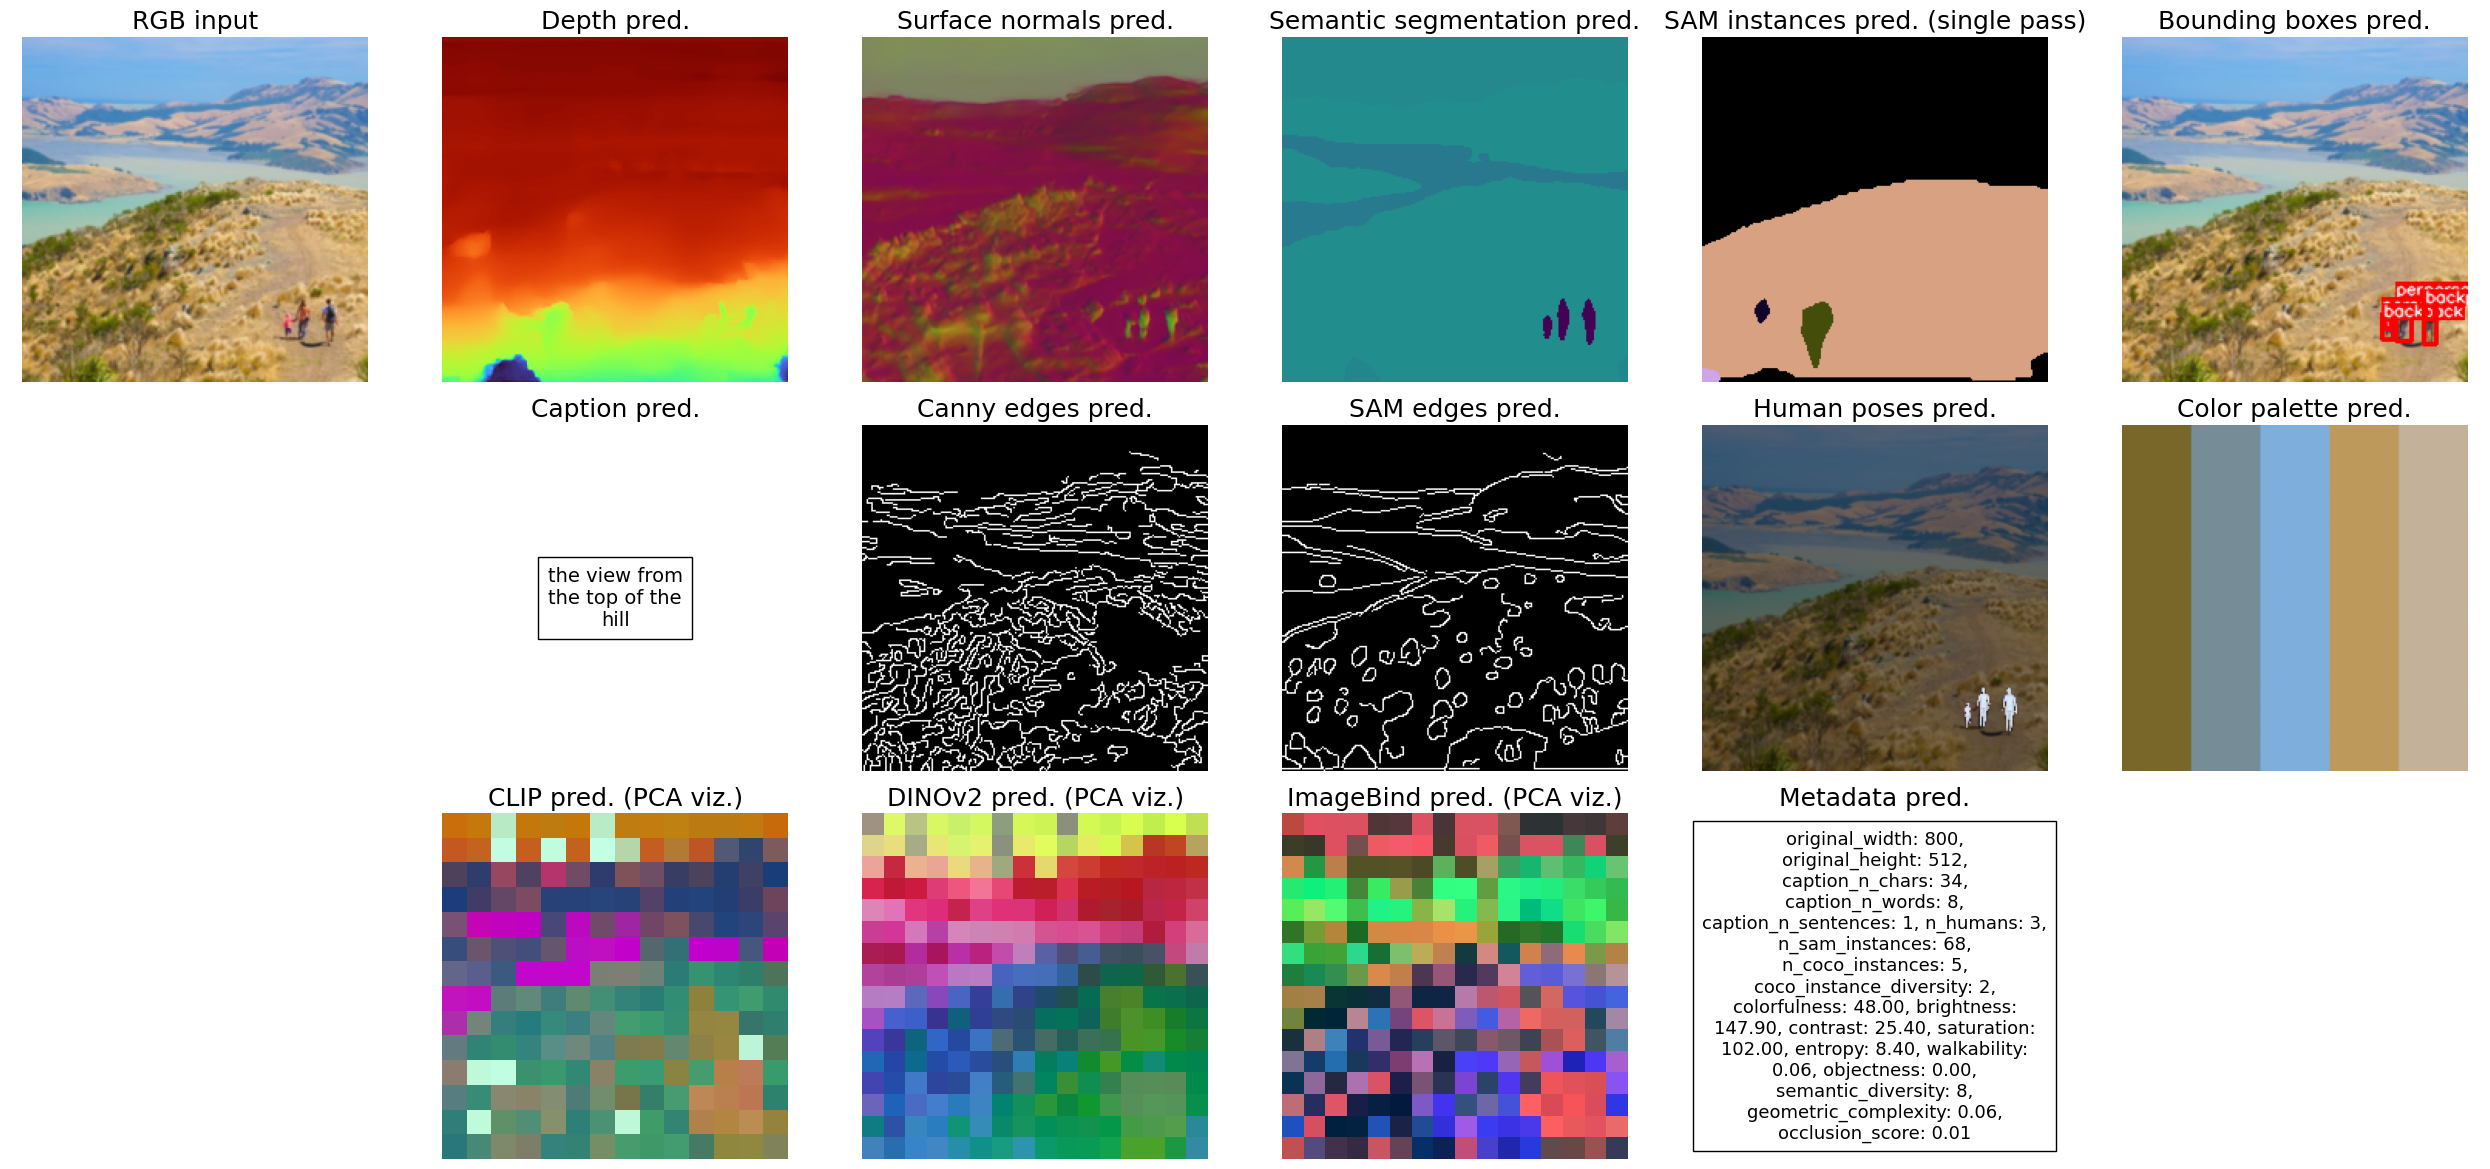

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(25,12), facecolor=(1, 1, 1))

ax[0,0].imshow(img_pil)
ax[0,0].set_title('RGB input', fontsize=18)

ax[0,1].imshow(dec_dict['tok_depth@224'])
ax[0,1].set_title('Depth pred.', fontsize=18)

ax[0,2].imshow(dec_dict['tok_normal@224'])
ax[0,2].set_title('Surface normals pred.', fontsize=18)

ax[0,3].imshow(dec_dict['tok_semseg@224'])
ax[0,3].set_title('Semantic segmentation pred.', fontsize=18)

ax[0,4].imshow(dec_dict['sam_instance'])
ax[0,4].set_title('SAM instances pred. (single pass)', fontsize=18)

ax[0,5].imshow(visualize_bboxes(np.array(img_pil), dec_dict['det'][0],))
ax[0,5].set_title('Bounding boxes pred.', fontsize=18)

plot_text_in_square(ax[1,1], dec_dict['caption'][0], wrap_width=16, fontsize=14)
ax[1,1].set_title('Caption pred.', fontsize=18)

ax[1,2].imshow(dec_dict['tok_canny_edge@224'], cmap='gray')
ax[1,2].set_title('Canny edges pred.', fontsize=18)

ax[1,3].imshow(dec_dict['tok_sam_edge@224'], cmap='gray')
ax[1,3].set_title('SAM edges pred.', fontsize=18)

ax[1,4].imshow(dec_dict['human_poses'])
ax[1,4].set_title('Human poses pred.', fontsize=18)

ax[1,5].imshow(dec_dict['color_palette'])
ax[1,5].set_title('Color palette pred.', fontsize=18)

ax[2,1].imshow(dec_dict['tok_clip@224'])
ax[2,1].set_title('CLIP pred. (PCA viz.)', fontsize=18)

ax[2,2].imshow(dec_dict['tok_dinov2@224'])
ax[2,2].set_title('DINOv2 pred. (PCA viz.)', fontsize=18)

ax[2,3].imshow(dec_dict['tok_imagebind@224'])
ax[2,3].set_title('ImageBind pred. (PCA viz.)', fontsize=18)

metadata_pred = ',\n'.join([f'{k}: {v:.2f}' if isinstance(v, float) else f'{k}: {v}' for k, v in dec_dict['metadata'].items()])
plot_text_in_square(ax[2,4], metadata_pred, wrap_width=36, fontsize=13)
ax[2,4].set_title('Metadata pred.', fontsize=18)

for axis in ax.flatten():
    axis.set_axis_off()

plt.tight_layout()
plt.show()

### Dense SAM instances prediction

To obtain a dense prediction of SAM instances, we implemented a separate method `.generate_sam_dense` that makes multiple SAM instance predictions with different seeds and merges their outputs. The method accepts the same inputs as `.generate` as well as an additional input `batch_size` which specifies the number of predictions. Increasing the `batch_size‍‍` leads to a denser output at the expense of longer processing.

In [10]:
cond_domains = ['rgb@224']
target_domains = ['sam_instance']
tokens_per_target = [256]
autoregression_schemes = ['autoregressive']
decoding_steps = [None]
token_decoding_schedules = [ None]
temps = [0.01]
temp_schedules = ['constant'] * len(target_domains)
cfg_scales = [1.0]
cfg_schedules = ['constant'] * len(target_domains)
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

In [11]:
batched_sample = {
    'rgb@224': {
        'tensor': img, # Batched tensor
        'input_mask': torch.zeros(1, 196, dtype=torch.bool, device=device), # False = used as input, True = ignored
        'target_mask': torch.ones(1, 196, dtype=torch.bool, device=device), # False = predicted as target, True = ignored
    }
}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)
    
# Initialize input modalities
for cond_mod in cond_domains:
    batched_sample = init_full_input_modality(batched_sample, MODALITY_INFO, cond_mod, device, eos_id=text_tok.token_to_id("[EOS]"))

In [12]:
# In the method the only target_domain considered in the schedule is sam_instance
out_dict = sampler.generate_sam_dense(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=True, seed=0,
    top_p=top_p, top_k=top_k, batch_size=32,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

1it [04:29, 269.23s/it]


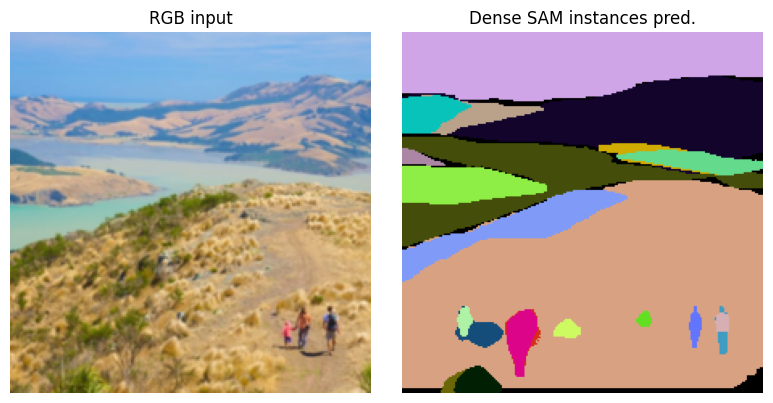

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), facecolor=(1, 1, 1))

ax[0].imshow(img_pil)
ax[0].set_title('RGB input')

ax[1].imshow(dec_dict['sam_instance'])
ax[1].set_title('Dense SAM instances pred.')

for axis in ax.flatten():
    axis.set_axis_off()

plt.tight_layout()
plt.show()